In [360]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from scipy.special import softmax

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, plot_importance

In [265]:
df_matches = pd.read_csv("matches.csv")

In [266]:
df_matches["leagueSeason"].value_counts()

leagueSeason
2010    306
2011    306
2012    306
2013    306
2014    306
2015    306
2016    306
2017    306
2018    306
2019    306
2020    306
2021    306
2022    306
2023    306
Name: count, dtype: int64

In [267]:
df_matches.sort_values("leagueSeason")
splits = []
split_test_seasons = []
years = df_matches["leagueSeason"].unique()
for i in range(1, len(years)):
    min_year = years[0]
    test_year = years[i]
    train_rows = df_matches[(df_matches["leagueSeason"] >= min_year) & (df_matches["leagueSeason"] < test_year)]
    test_rows = df_matches[df_matches["leagueSeason"] == test_year]
    splits.append((train_rows.index, test_rows.index))
    split_test_seasons.append(years[i])

splits[0]


(Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
        ...
        296, 297, 298, 299, 300, 301, 302, 303, 304, 305],
       dtype='int64', length=306),
 Index([306, 307, 308, 309, 310, 311, 312, 313, 314, 315,
        ...
        602, 603, 604, 605, 606, 607, 608, 609, 610, 611],
       dtype='int64', length=306))

In [268]:
def to_labels(df):
    return np.array(df[["team1Goals", "team2Goals"]].values)

to_labels(df_matches)

array([[2, 1],
       [4, 1],
       [1, 1],
       ...,
       [4, 1],
       [4, 0],
       [4, 1]])

In [269]:
class StaticEstimator(BaseEstimator):
    def __init__(self, result) -> None:
        super().__init__()
        self.result = result

    def fit(self, X, y):
        pass

    def predict(self, X):
        results = np.zeros((len(X), 2))
        results[:] = self.result
        return results



In [270]:
def compute_kicktipp_score(predictions, y):
    predictions_draw = predictions[:, 0] == predictions[:, 1]
    predictions_win1 = predictions[:, 0] > predictions[:, 1]
    predictions_win2 = predictions[:, 0] < predictions[:, 1]
    predictions_diff = predictions[:, 0] - predictions[:, 1]
    y_draw = y[:, 0] == y[:, 1]
    y_win1 = y[:, 0] > y[:, 1]
    y_win2 = y[:, 0] < y[:, 1]
    y_diff = y[:, 0] - y[:, 1]

    correct_result = (predictions[:, 0] == y[:, 0]) & (predictions[:, 1] == y[:, 1])
    correct_result_win = (correct_result & y_win1) | (correct_result & y_win2)
    correct_result_draw = correct_result & (~correct_result_win)
    correct_tendency_win = (predictions_win1 & y_win1) | (predictions_win2 & y_win2)
    correct_tendency_draw = (predictions_draw & y_draw)
    correct_diff_win = (predictions_diff == y_diff) & correct_tendency_win

    score = 0
    score += np.count_nonzero(correct_result) * 4
    score += np.count_nonzero(correct_diff_win & (~correct_result)) * 3
    score += np.count_nonzero(correct_tendency_draw & (~correct_result_draw)) * 2
    score += np.count_nonzero(correct_tendency_win & (~correct_result_win) & ~(correct_diff_win)) * 2
    return score

def kicktipp_scoring(estimator, X, y):
    predictions = estimator.predict(X)
    return compute_kicktipp_score(predictions, y)

assert compute_kicktipp_score(np.array([[0, 0], [1, 1]]), np.array([[0, 0], [1, 1]])) == 8
assert compute_kicktipp_score(np.array([[0, 0], [2, 1]]), np.array([[0, 0], [1, 1]])) == 4
assert compute_kicktipp_score(np.array([[0, 0], [1, 1]]), np.array([[0, 0], [1, 2]])) == 4
assert compute_kicktipp_score(np.array([[0, 0], [2, 1]]), np.array([[0, 0], [1, 0]])) == 7
assert compute_kicktipp_score(np.array([[1, 0], [2, 1]]), np.array([[0, 0], [1, 0]])) == 3
assert compute_kicktipp_score(np.array([[1, 3], [1, 1], [3, 0], [1, 1], [0, 2], [1, 1], [3, 1], [1, 3], [1, 1]]), np.array([[2, 3], [3, 2], [1, 0], [2, 2], [3, 1], [1, 1], [2, 0], [2, 3], [0, 2]])) == 15


In [271]:
static_results = [[0, 0], [1, 1], [1, 0], [0, 1]]
static_result_scores = []
for result in static_results:
    scores = cross_val_score(StaticEstimator(result), df_matches, to_labels(df_matches), cv=splits, scoring=kicktipp_scoring)
    static_result_scores.append(scores)

static_result_scores = np.array(static_result_scores)
print(static_result_scores.shape)

(4, 13)


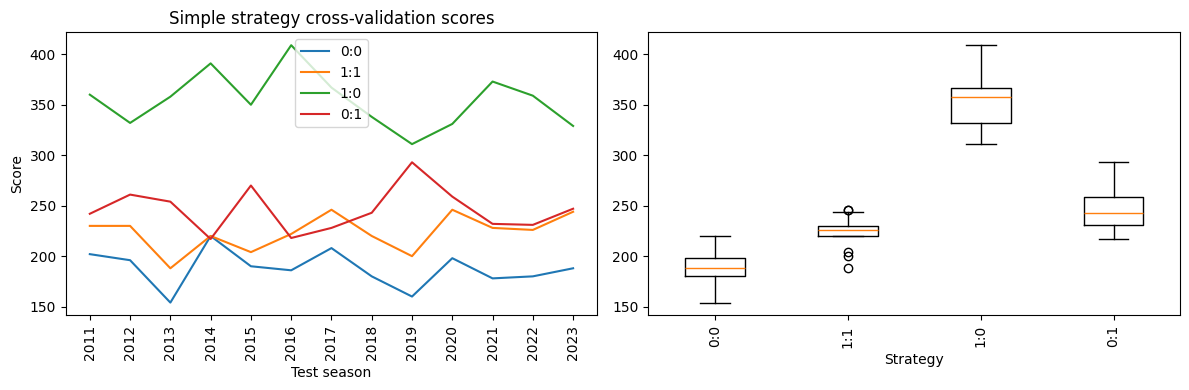

In [272]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
axs[0].plot(static_result_scores.T, label=[f"{res[0]}:{res[1]}" for res in static_results])
axs[0].set_xticks(range(len(split_test_seasons)), split_test_seasons, rotation=90, ha='center')
axs[0].set_xlabel("Test season")
axs[0].set_ylabel("Score")
axs[0].legend()
axs[0].set_title("Simple strategy cross-validation scores")

axs[1].boxplot(static_result_scores.T)
axs[1].set_xlabel("Strategy")
axs[1].set_xticks(range(1, len(static_results) +1), [f"{res[0]}:{res[1]}" for res in static_results], rotation=90, ha='center')
fig.tight_layout()
!

## Latest result model

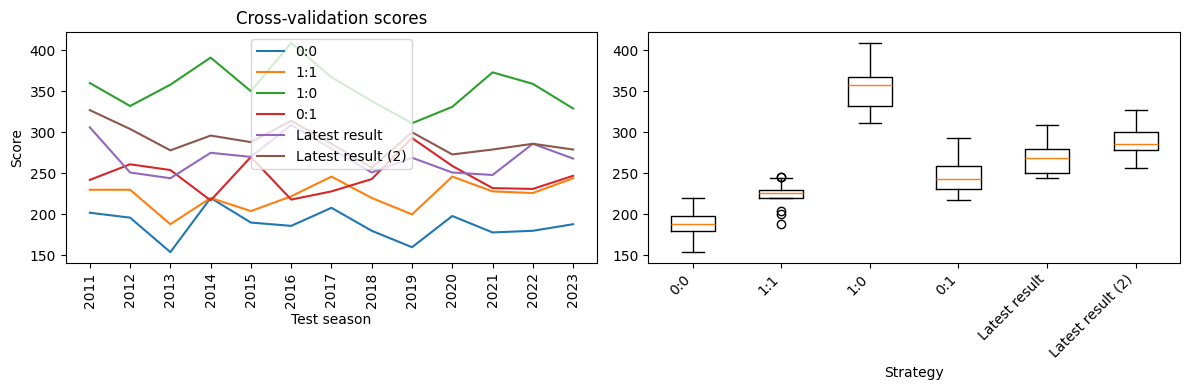

In [273]:
def find_latest_match(df_matches, short1, short2):
    mask = (df_matches["team1Short"] == short1) & (df_matches["team2Short"] == short2)
    mask = mask | (df_matches["team2Short"] == short1) & (df_matches["team1Short"] == short2)
    masked = df_matches.loc[mask, "date"]
    if len(masked) == 0:
        return None
    latest_match = masked.idxmax()
    return df_matches.iloc[latest_match]


class LatestResultEstimator(BaseEstimator):

    def __init__(self, default) -> None:
        super().__init__()
        self.default = default

    def fit(self, X, y):
        self.X_train = X

    def predict(self, X: pd.DataFrame):
        results = []
        for index, row in X.iterrows():
            latest_match = find_latest_match(self.X_train, row["team1Short"], row["team2Short"])
            if latest_match is None:
                results.append(self.default)
            else:
                results.append(to_labels(latest_match))

        return np.array(results)

def get_teams_of_latest_season(df_matches):
    season = df_matches["leagueSeason"].max()
    return df_matches.loc[df_matches["leagueSeason"] == season, "team1Short"].unique()

class LatestResultEstimatorPromotedLoose(BaseEstimator):

    def __init__(self) -> None:
        super().__init__()

    def fit(self, X, y):
        self.X_train = X
        self.teams_of_latest_season = get_teams_of_latest_season(X)

    def predict(self, X: pd.DataFrame):
        results = []
        for index, row in X.iterrows():
            team1 = row["team1Short"]
            team2 = row["team2Short"]
            latest_match = find_latest_match(self.X_train, team1, team2)
            if latest_match is None:
                if (team1 not in self.teams_of_latest_season) and (team2 not in self.teams_of_latest_season):
                    results.append([0, 0])
                elif team1 in self.teams_of_latest_season:
                    results.append([1, 0])
                elif team2 in self.teams_of_latest_season:
                    results.append([0, 1])
                else:
                    raise ValueError(f"A match between {team1} and {team2} must exist")
            else:
                results.append(to_labels(latest_match))

        return np.array(results)

latest_result_scores = cross_val_score(LatestResultEstimator([0, 0]), df_matches, to_labels(df_matches), cv=splits, scoring=kicktipp_scoring)
latest_result_promoter_scores = cross_val_score(LatestResultEstimatorPromotedLoose(), df_matches, to_labels(df_matches), cv=splits, scoring=kicktipp_scoring)

all_scores = np.vstack((static_result_scores, latest_result_scores, latest_result_promoter_scores))
labels = [f"{res[0]}:{res[1]}" for res in static_results] + ["Latest result", "Latest result (2)"]

fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
axs[0].plot(all_scores.T, label=labels)
axs[0].set_xticks(range(len(split_test_seasons)), split_test_seasons, rotation=90, ha='center')
axs[0].set_xlabel("Test season")
axs[0].set_ylabel("Score")
axs[0].legend()
axs[0].set_title("Cross-validation scores")

axs[1].boxplot(all_scores.T)
axs[1].set_xlabel("Strategy")
axs[1].set_xticks(range(1, len(labels) +1), labels, rotation=45, ha="right")
fig.tight_layout()
!

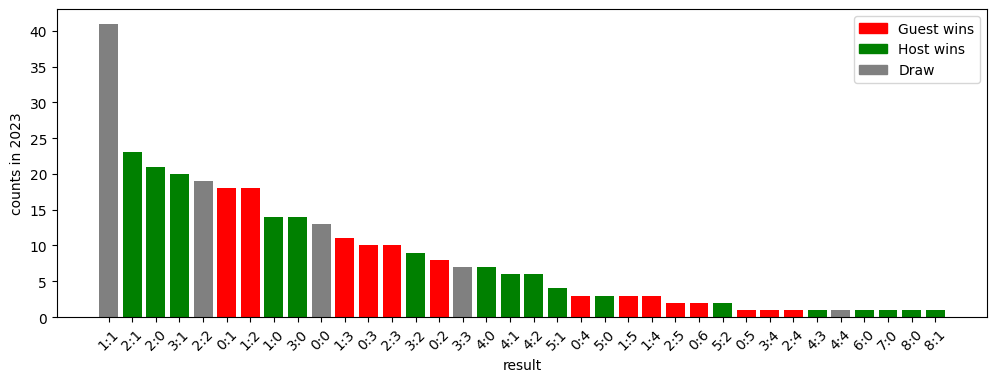

In [274]:

labels = to_labels(df_matches)
split = splits[-1]
train, test = df_matches.iloc[split[0]], df_matches.iloc[split[1]]
y_train, y_test = labels[split[0]], labels[split[1]]

baseline_model.fit(train, y_train)
y_pred = baseline_model.predict(test)
y_test_encoded = [f"{r[0]}:{r[1]}" for r in y_test]
results, counts = np.unique(y_test_encoded, return_counts=True)
sort = np.argsort(-counts)
counts = counts[sort]
results = results[sort]
tendency = [1] * len(results)
for i, res in enumerate(results):
    goals = res.split(":")
    if goals[0] > goals[1]:
        tendency[i] = 0
    elif goals[0] < goals[1]:
        tendency[i] = 2

y_test_colors = [["green", "gray", "red"][r] for r in tendency]
fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(range(len(results)), counts, color=y_test_colors)
ax.set_xlabel("result")
ax.set_ylabel(f"counts in {test.iloc[0]["leagueSeason"]}")
ax.set_xticks(range(len(results)), results, rotation=45)

red_patch = mpatches.Patch(color='red', label='Guest wins')
green_patch = mpatches.Patch(color='green', label='Host wins')
gray_patch = mpatches.Patch(color='gray', label='Draw')
ax.legend(handles=[red_patch, green_patch, gray_patch])
!

# Matches with team context

In [284]:
df_teams = pd.read_csv("teams.csv")
df_teams.head()

,team,year,draw,goalDiff,goals,lost,matches,opponentGoals,points,won
0,6,2010,8.0,20.0,64.0,6.0,34.0,44.0,68.0,20.0
1,6,2011,9.0,8.0,52.0,10.0,34.0,44.0,54.0,15.0
2,6,2012,8.0,26.0,65.0,7.0,34.0,39.0,65.0,19.0
3,6,2013,4.0,19.0,60.0,11.0,34.0,41.0,61.0,19.0
4,6,2014,10.0,25.0,62.0,7.0,34.0,37.0,61.0,17.0


In [286]:
df_matches.head(1)

,id,date,matchDay,matchDayID,leagueID,leagueName,leagueSeason,team1ID,team1Name,team1Short,team2ID,team2Name,team2Short,team1Goals,team2Goals,result
0,9998,2010-08-20T18:30:00Z,1. Spieltag,1,159,1. Fussball-Bundesliga 2010/2011,2010,40,FC Bayern München,Bayern,131,VfL Wolfsburg,Wolfsburg,2,1,Endergebnis


In [338]:
def add_last_season_context(df_matches: pd.DataFrame, df_teams: pd.DataFrame):
    df_matches = df_matches.copy()
    df_matches["last_season"] = df_matches["leagueSeason"] - 1
    df_teams_host = df_teams.copy()
    df_teams_host.columns = "host_" + df_teams_host.columns
    df_teams_guest = df_teams.copy()
    df_teams_guest.columns = "guest_" + df_teams_guest.columns
    df_full = pd.merge(how="left", left=df_matches, left_on=["team1ID", "last_season"], right=df_teams_host, right_on=["host_team", "host_year"], validate="m:1")
    df_full = pd.merge(how="left", left=df_full, left_on=["team2ID", "last_season"], right=df_teams_guest, right_on=["guest_team", "guest_year"], validate="m:1")
    df_full = df_full.fillna(-1)
    return df_full

df_full = add_last_season_context(df_matches, df_teams)


In [340]:
df_full = df_full.sort_values("leagueSeason")
splits = []
split_test_seasons = []
years = df_full["leagueSeason"].unique()
for i in range(2, len(years)):
    min_year = years[0]
    test_year = years[i]
    train_rows = df_full[(df_full["leagueSeason"] >= min_year) & (df_full["leagueSeason"] < test_year)]
    test_rows = df_full[df_full["leagueSeason"] == test_year]
    splits.append((train_rows.index, test_rows.index))
    split_test_seasons.append(years[i])

splits[1]

(Index([ 25,  24,  23,  22,  21,  20,  19,  18,  17,  16,
        ...
        674, 675, 676, 677, 678, 679, 680, 681, 612, 649],
       dtype='int64', length=918),
 Index([919, 918, 937, 936, 967, 966, 965, 964, 931, 930,
        ...
        955, 954, 985, 984, 983, 982, 981, 980, 921, 948],
       dtype='int64', length=306))

In [342]:
X_all = df_full.drop(columns=["team1Goals", "team2Goals", "result", "leagueName", "leagueID"])
y_all = df_full[["team1Goals", "team2Goals"]].values

In [343]:
features = ['leagueSeason', 'team1ID', 'team2ID',
            'host_lost','host_points', 'host_won', 'host_draw', 'host_goals',  'host_opponentGoals', 'host_goalDiff', 
            'guest_lost','guest_points', 'guest_won', 'guest_draw', 'guest_goals',  'guest_opponentGoals', 'guest_goalDiff', 
            ]
X_all = X_all[features]


In [394]:
class RegressorEstimator(BaseEstimator):
    def __init__(self, regressor, **kwargs) -> None:
        super().__init__()
        self.regressor = regressor
        self.regressor.set_params(**kwargs)
    
    
    def fit(self, X, y):
        self.regressor.fit(X, y)
    
    def predict(self, X):
        raw = self.regressor.predict(X)
        return np.round(raw).astype(int)
    
    def get_params(self, deep = False):
        params = self.regressor.get_params(deep)
        params["regressor"] = self.regressor
        return params

    def set_params(self, **params):
        self.regressor.set_params(**params)
        return self

In [393]:
param_grid = {
    "max_depth": [None, 4, 6, 8]
}
grid_search = GridSearchCV(RegressorEstimator(RandomForestRegressor()), param_grid, scoring=kicktipp_scoring, cv=splits)
grid_search.fit(X_all, y_all)

ValueError: 
All the 48 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "/home/niklas/Documents/projects/kicktipp-betbot/.env/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/tmp/ipykernel_14671/680203807.py", line 9, in fit
    self.regressor.fit(X, y, kwargs)
  File "/home/niklas/Documents/projects/kicktipp-betbot/.env/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/niklas/Documents/projects/kicktipp-betbot/.env/lib/python3.12/site-packages/sklearn/ensemble/_forest.py", line 383, in fit
    sample_weight = _check_sample_weight(sample_weight, X)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/niklas/Documents/projects/kicktipp-betbot/.env/lib/python3.12/site-packages/sklearn/utils/validation.py", line 2043, in _check_sample_weight
    sample_weight = check_array(
                    ^^^^^^^^^^^^
  File "/home/niklas/Documents/projects/kicktipp-betbot/.env/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1012, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/niklas/Documents/projects/kicktipp-betbot/.env/lib/python3.12/site-packages/sklearn/utils/_array_api.py", line 751, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: float() argument must be a string or a real number, not 'dict'


Scoring StaticEstimator(result=[1, 0])
Scoring RegressorEstimator(bootstrap=True, ccp_alpha=0.0, criterion='squared_error',
                   max_depth=2, max_features=1.0, max_leaf_nodes=None,
                   max_samples=None, min_impurity_decrease=0.0,
                   min_samples_leaf=1, min_samples_split=2,
                   min_weight_fraction_leaf=0.0, monotonic_cst=None,
                   n_estimators=100, n_jobs=None, oob_score=False,
                   random_state=None,
                   regressor=RandomForestRegressor(max_depth=2), verbose=0,
                   warm_start=False)
Scoring RegressorEstimator(bootstrap=True, ccp_alpha=0.0, criterion='squared_error',
                   max_depth=4, max_features=1.0, max_leaf_nodes=None,
                   max_samples=None, min_impurity_decrease=0.0,
                   min_samples_leaf=1, min_samples_split=2,
                   min_weight_fraction_leaf=0.0, monotonic_cst=None,
                   n_estimators=100, n_jobs=N

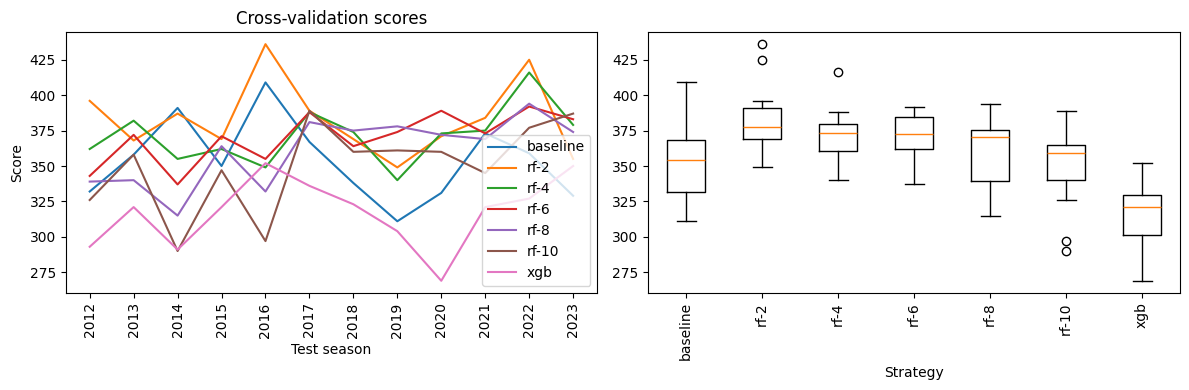

In [395]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, plot_importance

models = {
    "baseline": StaticEstimator([1, 0]),
    "rf-2": RegressorEstimator(RandomForestRegressor(max_depth=2)),
    "rf-4": RegressorEstimator(RandomForestRegressor(max_depth=4)),
    "rf-6": RegressorEstimator(RandomForestRegressor(max_depth=6)),
    "rf-8": RegressorEstimator(RandomForestRegressor(max_depth=8)),
    "rf-10": RegressorEstimator(RandomForestRegressor(max_depth=10)),
    "xgb": RegressorEstimator(XGBRegressor()),
}

all_scores = []

for model in models.values():
    print(f"Scoring {model}")
    scores = cross_val_score(model, X_all, y_all, cv=splits, verbose=1, scoring=kicktipp_scoring)
    all_scores.append(scores)

all_scores = np.array(all_scores)
labels = models.keys()

fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
axs[0].plot(all_scores.T, label=labels)
axs[0].set_xticks(range(len(split_test_seasons)), split_test_seasons, rotation=90, ha='center')
axs[0].set_xlabel("Test season")
axs[0].set_ylabel("Score")
axs[0].legend()
axs[0].set_title("Cross-validation scores")

axs[1].boxplot(all_scores.T)
axs[1].set_xlabel("Strategy")
axs[1].set_xticks(range(1, len(labels) +1), labels, rotation=90, ha="center")
fig.tight_layout()
!


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

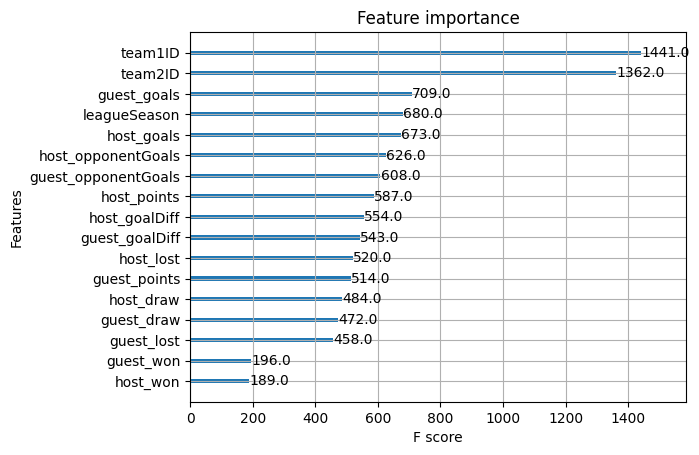

In [357]:
regressor = XGBRegressor()
regressor.fit(X_all, y_all)
plot_importance(regressor)